# Quantifying Sabotage in Simple Sabotage Matrix Game

Simple sabotage is a fully cooperative, iterated matrix game with the following payoffs: 
```
[[1, 0, -1], 
[0, 1, -1], 
[-1, -1, -1]]
```

Both agent has 3 actions: H(ead), T(ail), and S(abotage).
Each agent's observation is the history of joint actions taken by both agents.
The game ends either when the time limit is reached or if an agent takes the sabotage action.


In [ ]:
import os
os.chdir(os.path.dirname(os.getcwd()))
from pathlib import Path
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from agents.initialize_agents import initialize_actor_with_double_critic
from common.save_load_utils import load_train_run
from envs import make_env

%matplotlib inline
%load_ext autoreload

/scratch/cluster/clw4542/conda_envs/oeaht/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
BASE_PATH = Path("/scratch/cluster/clw4542/explore_marl/continual-aht/")
RESULTS_DIRNAME = Path("results/simple_sabotage/")

per_traj_regret_ckpt_path = BASE_PATH / RESULTS_DIRNAME / "rotate" / "paper-v0:treg" / "2025-09-24_10-51-42" / "saved_train_run" 
per_state_regret_ckpt_path = BASE_PATH / RESULTS_DIRNAME / "rotate" / "paper-v0:breg" / "2025-09-24_13-08-14" / "saved_train_run" 

In [ ]:
# Load the checkpoint
# teammate_out, ego_out = load_train_run(per_traj_regret_ckpt_path)
teammate_out, ego_out = load_train_run(per_state_regret_ckpt_path)

/scratch/cluster/clw4542/conda_envs/oeaht/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1167: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [ ]:
def get_action_distribution(actor_with_double_critic_policy, params, agent_obs):
    '''Get the action distribution for a given agent and observation.'''
    action, (val1, val2), pi, _ = actor_with_double_critic_policy.get_action_value_policy(
        params=params,
        obs=agent_obs.reshape(1, 1, -1),
        done=None, 
        avail_actions=jnp.ones(3, dtype=jnp.int32),
        hstate=None, # actor with double critic is not recurrent
        rng=jax.random.PRNGKey(0) # only used to generate the action which we don't care about
        )
    return pi.probs

# Initialize the teammate policy
# ROTATE teammate is an actor with double critic
init_rng = jax.random.PRNGKey(0)
env = make_env("simple_sabotage", env_kwargs={"max_steps": 5, "max_history_len": 5})
policy, init_params = initialize_actor_with_double_critic({}, env, init_rng)

# Get the params for the teammate policy
# shape is (num_ckpts, num_oel_iter, 1, -1)
oel0_teammate_params = jax.tree.map(lambda x: x[0, -1, 0], teammate_out['final_params_conf'])

# Get the action distribution for the teammate policy
obs, state = env.reset(init_rng) # random key is unused in this environment
action_probs = get_action_distribution(policy, oel0_teammate_params, obs['agent_0'])
print(action_probs.shape)

(1, 1, 3)


## Generate Possible Observations

In [71]:
def generate_all_possible_observations(max_history_len):
    """
    Generate all possible observations for the simple sabotage environment.
    
    Each observation is a vector of length 2*max_history_len.
    The observation represents the history of joint actions taken by both agents.
    Actions are encoded as: 0=Head, 1=Tail, 2=Sabotage
    Unused timesteps are encoded as -1.
    
    Key constraints:
    - If any agent takes sabotage action (2), the episode ends immediately
    - This means no valid actions can follow a sabotage action
    
    Returns:
        List of all valid observation vectors
    """
    all_observations = []
    
    def is_valid_history(history):
        """Check if a history is valid (no actions after sabotage)."""
        for i, (a0, a1) in enumerate(history):
            if a0 == 2 or a1 == 2:  # Sabotage action taken
                # Check that all subsequent actions are -1 (unused)
                for j in range(i + 1, len(history)):
                    if history[j][0] != -1 or history[j][1] != -1:
                        return False
                break
        return True
    
    def generate_histories(current_history, timestep):
        """Recursively generate all valid histories."""
        
        # If we're at timestep 0, start with empty history (all -1s)
        if timestep == 0:
            empty_history = [(-1, -1)] * max_history_len
            obs = []
            for a0, a1 in empty_history:
                obs.extend([a0, a1])
            all_observations.append(jnp.array(obs, dtype=jnp.int32))
        
        # If we've reached the max history length, convert to flat observation format
        if timestep >= max_history_len:
            obs = []
            for a0, a1 in current_history:
                obs.extend([a0, a1])
            all_observations.append(jnp.array(obs, dtype=jnp.int32))
            return
        
        # Try all possible joint actions at this timestep
        for a0 in range(3):  # Actions: 0, 1, 2
            for a1 in range(3):
                new_history = current_history.copy()
                new_history[timestep] = (a0, a1)
                
                # Fill remaining timesteps with -1
                for i in range(timestep + 1, max_history_len):
                    new_history[i] = (-1, -1)
                
                if is_valid_history(new_history):
                    # Convert to flat observation format
                    obs = []
                    for agent0_action, agent1_action in new_history:
                        obs.extend([agent0_action, agent1_action])
                    all_observations.append(jnp.array(obs, dtype=jnp.int32))
                    
                    # If no sabotage was taken, continue to next timestep
                    if a0 != 2 and a1 != 2:
                        generate_histories(new_history, timestep + 1)
    
    # Start with empty history
    initial_history = [(-1, -1)] * max_history_len
    generate_histories(initial_history, 0)
    
    # Remove duplicates 
    all_obs_as_tuples = [tuple(obs.tolist()) for obs in all_observations]
    unique_observations = set(all_obs_as_tuples)
    unique_observations = [jnp.array(obs) for obs in unique_observations]

    return unique_observations


def filter_terminal_obs(all_obs):
    """
    Filter out all terminal observations.
    """
    filtered_all_obs = []
    for obs in all_obs:
        # Check if any agent took the sabotage action
        if 2 in obs:
            continue
        # If history is entirely filled, then the ep is done due to the max_steps limit
        if -1 not in obs: 
            continue
        filtered_all_obs.append(obs)
    return filtered_all_obs

# Generate all possible observations
print("Generating all possible observations...")
all_obs = generate_all_possible_observations(max_history_len=5)
print(f"Total number of unique observations: {len(all_obs)}")

# Filter out all observations with sabotage
filtered_all_obs = filter_terminal_obs(all_obs)
print(f"Total number of unique observations after filtering: {len(filtered_all_obs)}")

Generating all possible observations...
Total number of unique observations: 3070
Total number of unique observations after filtering: 341


# Analyze Sabotage Probabilities over State Space

## Util Functions

In [141]:
@jax.jit
def batch_get_action_distributions(params, obs_batch):
    """
    Get action distributions for a batch of observations using JIT compilation.
    
    Args:
        params: Agent parameters
        obs_batch: Batch of observations with shape (batch_size, obs_dim)
        
    Returns:
        Action probability distributions with shape (batch_size, 3)
    """
    # Get action distributions for all observations in the batch
    def get_single_action_dist(obs):
        action, (val1, val2), pi, _ = policy.get_action_value_policy(
            params=params,
            obs=obs.reshape(1, 1, -1),
            done=None,
            avail_actions=jnp.ones(3, dtype=jnp.int32),
            hstate=None,
            rng=jax.random.PRNGKey(0)
        )
        return pi.probs[0, 0]  # Return just the probability distribution
    
    # Use vmap to vectorize over the batch dimension
    batch_probs = jax.vmap(get_single_action_dist)(obs_batch)
    
    return batch_probs

def analyze_sabotage_probabilities(all_observations, params, batch_size=512):
    """
    Analyze the probability of sabotage action for each possible observation.
    Uses JIT compilation and batching for efficient computation.
    
    Args:
        all_observations: List of all possible observation vectors
        params: Agent parameters
        batch_size: Number of observations to process in each batch
        
    Returns:
        Dictionary with analysis results
    """
    # Convert observations to a stacked array for efficient batching
    obs_array = jnp.stack(all_observations)
    num_obs = len(all_observations)
        
    # Process observations in batches
    all_action_probs = []
    for i in range(0, num_obs, batch_size):
        end_idx = min(i + batch_size, num_obs)
        batch_obs = obs_array[i:end_idx]
        
        # Get action probabilities for this batch
        batch_probs = batch_get_action_distributions(params, batch_obs)
        all_action_probs.append(batch_probs)
    
    # Concatenate all batch results
    all_action_probs = jnp.concatenate(all_action_probs, axis=0)
    
    # Extract sabotage probabilities (action index 2)
    sabotage_probs = all_action_probs[:, 2].tolist()
    
    # Create detailed analysis for each observation
    observation_details = []
    action_names = {0: 'H', 1: 'T', 2: 'S', -1: '-'}
    
    for i, obs in enumerate(all_observations):
        # Decode the observation for interpretability
        history = obs.reshape(-1, 2)
        
        # Find the length of actual history (before -1s)
        history_length = 0
        for j, (a0, a1) in enumerate(history):
            if int(a0) == -1 and int(a1) == -1:  # Convert to int to avoid JAX array key issue
                break
            history_length = j + 1
        
        # Create readable history string
        if history_length == 0:
            history_str = "Empty (start of episode)"
        else:
            history_pairs = []
            for j in range(history_length):
                a0, a1 = int(history[j][0]), int(history[j][1])  # Convert to int
                history_pairs.append(f"({action_names[a0]},{action_names[a1]})")
            history_str = " -> ".join(history_pairs)
        
        observation_details.append({
            'obs_index': i,
            'history_length': history_length,
            'history_str': history_str,
            'sabotage_prob': sabotage_probs[i],
            'full_action_probs': all_action_probs[i].tolist()
        })
    
    # Sort by sabotage probability (descending)
    sorted_details = sorted(observation_details, key=lambda x: x['sabotage_prob'], reverse=True)
    
    return {
        'sabotage_probs': sabotage_probs,
        'observation_details': observation_details,
        'sorted_by_sabotage_prob': sorted_details,
        'avg_sabotage_prob': float(jnp.mean(jnp.array(sabotage_probs))),
        'max_sabotage_prob': float(jnp.max(jnp.array(sabotage_probs))),
        'min_sabotage_prob': float(jnp.min(jnp.array(sabotage_probs)))
    }

## Plot Sabotage Histogram for All Methods

In [140]:
def analyze_sabotage_all_seeds(filtered_all_obs, teammate_out, method_name):
    """
    Analyze sabotage probabilities across all seeds for a given method.
    
    Args:
        filtered_all_obs: List of non-terminal observations
        teammate_out: Loaded checkpoint data containing parameters for all seeds
        method_name: Name of the method for logging
        
    Returns:
        Dictionary with aggregated analysis results across all seeds
    """
    print(f"\nAnalyzing {method_name} across all seeds...")
    
    # Get the shape to understand how many seeds we have
    params_shape = jax.tree.leaves(teammate_out['final_params_conf'])[0].shape
    num_seeds = params_shape[0]
    print(f"Found {num_seeds} seeds")
    
    # Collect sabotage probabilities from all seeds
    all_seeds_sabotage_probs = []
    all_seeds_details = []
    
    for seed in range(num_seeds):
        # Extract parameters for this seed (last OEL iteration)
        seed_params = jax.tree.map(lambda x: x[seed, -1, 0], teammate_out['final_params_conf'])
        
        # Analyze sabotage probabilities for this seed
        seed_results = analyze_sabotage_probabilities(filtered_all_obs, seed_params)
        
        # Collect the sabotage probabilities
        all_seeds_sabotage_probs.extend(seed_results['sabotage_probs'])
        
        # Add seed information to observation details
        for detail in seed_results['observation_details']:
            detail['seed'] = seed
            all_seeds_details.append(detail)
    
    # Compute aggregate statistics
    all_seeds_sabotage_probs = np.array(all_seeds_sabotage_probs)
    
    return {
        'sabotage_probs': all_seeds_sabotage_probs.tolist(),
        'observation_details': all_seeds_details,
        'avg_sabotage_prob': float(np.mean(all_seeds_sabotage_probs)),
        'max_sabotage_prob': float(np.max(all_seeds_sabotage_probs)),
        'min_sabotage_prob': float(np.min(all_seeds_sabotage_probs)),
        'std_sabotage_prob': float(np.std(all_seeds_sabotage_probs)),
        'num_seeds': num_seeds,
        'num_observations_per_seed': len(filtered_all_obs),
        'total_observations': len(all_seeds_sabotage_probs)
    }

methods = {
    "ROTATE (per-state)": BASE_PATH / RESULTS_DIRNAME / "rotate" / "paper-v0:breg" / "2025-09-24_13-08-14" / "saved_train_run",  # 5 OEL iters,
    "ROTATE (per-traj)": BASE_PATH / RESULTS_DIRNAME / "rotate" / "paper-v0:treg" / "2025-09-24_10-51-42" / "saved_train_run"  # 5 OEL iters,
}

analysis_results_all_seeds = {}
for method, ckpt_path in methods.items():
    teammate_out, ego_out = load_train_run(ckpt_path)
    analysis_results_all_seeds[method] = analyze_sabotage_all_seeds(filtered_all_obs, teammate_out, method)

/scratch/cluster/clw4542/conda_envs/oeaht/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1167: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(



Analyzing ROTATE (per-state) across all seeds...
Found 3 seeds
  Processing seed 0...
Analyzing sabotage probabilities for all possible observations...
Processing 341 observations in batches of 512...
  Processing seed 1...
Analyzing sabotage probabilities for all possible observations...
Processing 341 observations in batches of 512...
  Processing seed 2...
Analyzing sabotage probabilities for all possible observations...
Processing 341 observations in batches of 512...

Analyzing ROTATE (per-traj) across all seeds...
Found 3 seeds
  Processing seed 0...
Analyzing sabotage probabilities for all possible observations...
Processing 341 observations in batches of 512...
  Processing seed 1...
Analyzing sabotage probabilities for all possible observations...
Processing 341 observations in batches of 512...
  Processing seed 2...
Analyzing sabotage probabilities for all possible observations...
Processing 341 observations in batches of 512...


Multi-seed Analysis Summary:


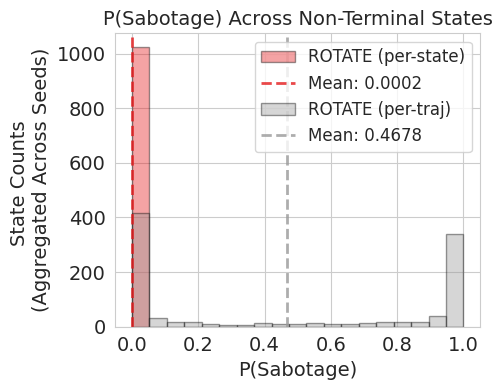

In [157]:
# Set title size, tick size, font size for all elements
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize'] = 14


def plot_sabotage_histogram_all_seeds(analysis_results_all: dict, save_path: str, save=False):
    '''Plot sabotage probabilities as a staggered histogram, aggregated across all seeds'''
    fig, axes = plt.subplots(figsize=(5, 4))

    bins = np.linspace(0, 1, 20)
    colors = plt.cm.Set1(np.linspace(0, 1, len(analysis_results_all)))
    
    print("Multi-seed Analysis Summary:")
    print("=" * 50)
    
    for i, (method_name, result) in enumerate(analysis_results_all.items()):
        # Plot histogram
        _, _, patches = axes.hist(result['sabotage_probs'], bins=bins, alpha=0.4, 
                                edgecolor='black', label=method_name, color=colors[i])
        
        # Plot mean line
        axes.axvline(result['avg_sabotage_prob'], 
                     color=colors[i], linestyle='--', alpha=0.8, linewidth=2,
                     label=f'Mean: {result["avg_sabotage_prob"]:.4f}')
        
    axes.set_xlabel('P(Sabotage)')
    axes.set_ylabel('State Counts \n(Aggregated Across Seeds)')
    axes.set_title('P(Sabotage) Across Non-Terminal States')
    
    plt.legend(loc='upper right')
    plt.tight_layout()
    if save:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot the multi-seed analysis results
plot_sabotage_histogram_all_seeds(analysis_results_all_seeds, 
    save_path="results/figures/sabotage_histogram_all.pdf", 
    save=True)